# Assignment 2

## Initialization

In [1]:
#@title Mount your Google Drive
# If you run this notebook locally or on a cluster (i.e. not on Google Colab)
# you can delete this cell which is specific to Google Colab. You may also
# change the paths for data/logs in Arguments below.
%matplotlib inline
%load_ext autoreload
%autoreload 2

from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [2]:
#@title Link your assignment folder & install requirements
#@markdown Enter the path to the assignment folder in your Google Drive
# If you run this notebook locally or on a cluster (i.e. not on Google Colab)
# you can delete this cell which is specific to Google Colab. You may also
# change the paths for data/logs in Arguments below.
import sys
import os
import shutil
import warnings

folder = "/content/gdrive/MyDrive/Udem/Sem2/Representation_Learning/IFT6135_Programming/assignment2/" #@param {type:"string"}
!ln -Ts "$folder" /content/assignment 2> /dev/null

# Add the assignment folder to Python path
if '/content/assignment' not in sys.path:
  sys.path.insert(0, '/content/assignment')

# Install requirements
!pip install -qr /content/assignment/requirements.txt

# Check if CUDA is available
import torch
if not torch.cuda.is_available():
  warnings.warn('CUDA is not available.')

### Running on GPU
For this assignment, it will be necessary to run your experiments on GPU. To make sure the notebook is running on GPU, you can change the notebook settings with
* (EN) `Edit > Notebook Settings`
* (FR) `Modifier > Paramètres du notebook`


In [3]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import torch.optim as optim
import urllib.request

from dataclasses import dataclass
from torch.utils.data import DataLoader
from tqdm import tqdm

from lstm_solution import LSTM
from utils.wikitext2 import Wikitext2
from utils.torch_utils import seed_experiment, to_device
from utils.data_utils import save_logs
from run_exp_lstm import train, evaluate


## Experiments

Below we define a few default arguments to get you started with your experiments. You are encouraged to modify the function `main()`, as well as these arguments, to fit your needs (e.g. changing hyperparameters, the optimizer, adding regularization, adding logs).

In [4]:
@dataclass
class Arguments:
  # Data
  data_folder: str = '/content/assignment/data'
  batch_size: int = 16

  # Model
  model: str = 'lstm'  # [lstm, gpt1]
  embeddings: str = '/content/assignment/data/embeddings.npz'
  layers: int = 1

  # Optimization
  optimizer: str = 'adamw'  # [sgd, momentum, adam, adamw]
  epochs: int = 10
  lr: float = 1e-3
  momentum: float = 0.9
  weight_decay: float = 5e-4

  # Experiment
  exp_id: str = 'debug'
  log: bool = True
  log_dir: str = '/content/assignment/logs'
  seed: int = 42

  # Miscellaneous
  num_workers: int = 2
  device: str = 'cuda'
  progress_bar: bool = False
  print_every: int = 10

The 6 configurations you need to run in Problem 1. Be careful that there is no discrepency between the configurations defined in `run_exp_lstm.py` and the ones below. In case there is a difference, the version from `run_exp_lstm.py` should be considered the ones to run.

In [ ]:
# Note: if there is any discrepency with the configurations in run_exp_lstm.py, the
# version from run_exp_lstm.py should be the ones to use in Problem 1.
configs = {
  1: Arguments(model='lstm', layers=1, batch_size=16, log=True, epochs=10, optimizer='adam'),
  2: Arguments(model='lstm', layers=1, batch_size=16, log=True, epochs=10, optimizer='adamw'),
  3: Arguments(model='lstm', layers=1, batch_size=16, log=True, epochs=10, optimizer='sgd'),
  4: Arguments(model='lstm', layers=1, batch_size=16, log=True, epochs=10, optimizer='momentum'),

  5: Arguments(model='lstm', layers=2, batch_size=16, log=True, epochs=10, optimizer='adamw'),
  6: Arguments(model='lstm', layers=4, batch_size=16, log=True, epochs=10, optimizer='adamw')
}

In [ ]:
def main(args):
  # Seed the experiment, for repeatability
  seed_experiment(args.seed)

  # Dataloaders
  train_dataset = Wikitext2(args.data_folder, split="train")
  train_dataloader = DataLoader(
    train_dataset,
    batch_size=args.batch_size,
    shuffle=True,
    num_workers=args.num_workers,
  )

  valid_dataset = Wikitext2(args.data_folder, split="validation")
  valid_dataloader = DataLoader(
    valid_dataset,
    batch_size=args.batch_size,
    shuffle=False,
    num_workers=args.num_workers,
  )

  test_dataset = Wikitext2(args.data_folder, split="test")
  test_dataloader = DataLoader(
    test_dataset,
    batch_size=args.batch_size,
    shuffle=False,
    num_workers=args.num_workers,
  )

  # Download the embeddings
  if not os.path.isfile(args.embeddings):
    print("Downloading embeddings...")
    urllib.request.urlretrieve(EMBEDDINGS_URL, args.embeddings)

  # Model
  if args.model == "lstm":
    model = LSTM.load_embeddings_from(
      args.embeddings, hidden_size=512, num_layers=args.layers
    )
  elif args.model == "gpt1":
    model = MiniGPT1.load_embeddings_from(
      args.embeddings, num_layers=args.layers
    )
  else:
    raise ValueError("Unknown model {0}".format(args.model))
  model.to(args.device)

  # Optimizer
  if args.optimizer == "adamw":
    optimizer = optim.AdamW(
      model.parameters(), lr=args.lr, weight_decay=args.weight_decay
    )
  elif args.optimizer == "adam":
    optimizer = optim.Adam(model.parameters(), lr=args.lr)
  elif args.optimizer == "sgd":
    optimizer = optim.SGD(
      model.parameters(), lr=args.lr, weight_decay=args.weight_decay
    )
  elif args.optimizer == "momentum":
    optimizer = optim.SGD(
      model.parameters(),
      lr=args.lr,
      momentum=args.momentum,
      weight_decay=args.weight_decay,
    )

  print(
    f"Initialized {args.model.upper()} model with {sum(p.numel() for p in model.parameters())} "
    f"total parameters, of which {sum(p.numel() for p in model.parameters() if p.requires_grad)} are learnable."
  )

  train_losses, valid_losses = [], []
  train_ppls, valid_ppls = [], []
  train_times, valid_times = [], []
  for epoch in range(args.epochs):

    tqdm.write(f"====== Epoch {epoch} ======>")

    loss, ppl, wall_time = train(epoch, model, train_dataloader, optimizer, args)
    train_losses.append(loss)
    train_ppls.append(ppl)
    train_times.append(wall_time)

    loss, ppl, wall_time = evaluate(epoch, model, valid_dataloader, args)
    valid_losses.append(loss)
    valid_ppls.append(ppl)
    valid_times.append(wall_time)

  test_loss, test_ppl, test_time = evaluate(
    epoch, model, test_dataloader, args, mode="test"
  )

  print(f"===== Best validation perplexity: {min(valid_ppls):.3f} =====>")

  return (
    train_losses,
    train_ppls,
    train_times,
    valid_losses,
    valid_ppls,
    valid_times,
    test_loss,
    test_ppl,
    test_time,
  )

In [ ]:
args = configs[6]  # Run the first configuration
logs = main(args)
if args.log:
  save_logs(args, *logs)

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
train_loss_1 = np.loadtxt("/content/assignment/logs/debug/train_loss.txt", dtype=float)
val_loss_1 = np.loadtxt("/content/assignment/logs/debug/valid_loss.txt", dtype=float)
train_ppl_1 = np.loadtxt("/content/assignment/logs/debug/train_ppl.txt", dtype=float)
val_ppl_1 = np.loadtxt("/content/assignment/logs/debug/valid_ppl.txt", dtype=float)
train_time_1 = np.loadtxt("/content/assignment/logs/debug/train_time.txt", dtype=float)
val_time_1 = np.loadtxt("/content/assignment/logs/debug/valid_time.txt", dtype=float)
epoch = [i for i in range(1,len(val_ppl_1)+1)]

In [ ]:
plt.plot(epoch, train_loss_1,label='train')
plt.plot(epoch, val_loss_1, label='valid')
plt.legend(loc='upper right')
plt.xlabel("Epoch")
plt.ylabel("Loss")

In [ ]:
plt.plot(epoch, train_time_1,label='train')
plt.plot(epoch, val_time_1, label='valid')
plt.legend(loc='upper right')
plt.xlabel("Perplexity")
plt.ylabel("Loss")

In [ ]:
train_loss_2 = np.loadtxt("/content/assignment/logs/debug/train_loss.txt", dtype=float)
val_loss_2 = np.loadtxt("/content/assignment/logs/debug/valid_loss.txt", dtype=float)
train_ppl_2 = np.loadtxt("/content/assignment/logs/debug/train_ppl.txt", dtype=float)
val_ppl_2 = np.loadtxt("/content/assignment/logs/debug/valid_ppl.txt", dtype=float)
train_time_2 = np.loadtxt("/content/assignment/logs/debug/train_time.txt", dtype=float)
val_time_2 = np.loadtxt("/content/assignment/logs/debug/valid_time.txt", dtype=float)

Text(0, 0.5, 'Loss')

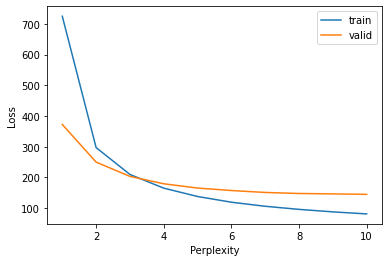

In [ ]:
import matplotlib.pyplot as plt
plt.plot(epoch, train_ppl_2,label='train')
plt.plot(epoch, val_ppl_2, label='valid')
plt.legend(loc='upper right')
plt.xlabel("Perplexity")
plt.ylabel("Loss")

In [ ]:
train_loss_3 = np.loadtxt("/content/assignment/logs/debug/train_loss.txt", dtype=float)
val_loss_3 = np.loadtxt("/content/assignment/logs/debug/valid_loss.txt", dtype=float)
train_ppl_3 = np.loadtxt("/content/assignment/logs/debug/train_ppl.txt", dtype=float)
val_ppl_3 = np.loadtxt("/content/assignment/logs/debug/valid_ppl.txt", dtype=float)
train_time_3 = np.loadtxt("/content/assignment/logs/debug/train_time.txt", dtype=float)
val_time_3 = np.loadtxt("/content/assignment/logs/debug/valid_time.txt", dtype=float)

In [ ]:
plt.plot(epoch, train_ppl_3,label='train')
plt.plot(epoch, val_ppl_3, label='valid')
plt.legend(loc='upper right')
plt.xlabel("epoch")
plt.ylabel("perplexity")

In [ ]:
train_loss_4 = np.loadtxt("/content/assignment/logs/debug/train_loss.txt", dtype=float)
val_loss_4 = np.loadtxt("/content/assignment/logs/debug/valid_loss.txt", dtype=float)
train_ppl_4 = np.loadtxt("/content/assignment/logs/debug/train_ppl.txt", dtype=float)
val_ppl_4 = np.loadtxt("/content/assignment/logs/debug/valid_ppl.txt", dtype=float)
train_time_4 = np.loadtxt("/content/assignment/logs/debug/train_time.txt", dtype=float)
val_time_4 = np.loadtxt("/content/assignment/logs/debug/valid_time.txt", dtype=float)

In [ ]:
train_loss_5 = np.loadtxt("/content/assignment/logs/debug/train_loss.txt", dtype=float)
val_loss_5 = np.loadtxt("/content/assignment/logs/debug/valid_loss.txt", dtype=float)
train_ppl_5 = np.loadtxt("/content/assignment/logs/debug/train_ppl.txt", dtype=float)
val_ppl_5 = np.loadtxt("/content/assignment/logs/debug/valid_ppl.txt", dtype=float)
train_time_5 = np.loadtxt("/content/assignment/logs/debug/train_time.txt", dtype=float)
val_time_5 = np.loadtxt("/content/assignment/logs/debug/valid_time.txt", dtype=float)

In [ ]:
train_loss_6 = np.loadtxt("/content/assignment/logs/debug/train_loss.txt", dtype=float)
val_loss_6 = np.loadtxt("/content/assignment/logs/debug/valid_loss.txt", dtype=float)
train_ppl_6 = np.loadtxt("/content/assignment/logs/debug/train_ppl.txt", dtype=float)
val_ppl_6 = np.loadtxt("/content/assignment/logs/debug/valid_ppl.txt", dtype=float)
train_time_6 = np.loadtxt("/content/assignment/logs/debug/train_time.txt", dtype=float)
val_time_6 = np.loadtxt("/content/assignment/logs/debug/valid_time.txt", dtype=float)

In [ ]:
import pandas as pd
dff = pd.DataFrame()
dff['epoch'] = epoch
dff['train_loss_1'] = train_loss_1
dff['train_loss_2'] = train_loss_2
dff['train_loss_3'] = train_loss_3
dff['train_loss_4'] = train_loss_4
dff['train_loss_5'] = train_loss_5
dff['train_loss_6'] = train_loss_6
dff['val_loss_1'] = val_loss_1
dff['val_loss_2'] = val_loss_2
dff['val_loss_3'] = val_loss_3
dff['val_loss_4'] = val_loss_4
dff['val_loss_5'] = val_loss_5
dff['val_loss_6'] = val_loss_6
dff['train_ppl_1'] = train_ppl_1
dff['train_ppl_2'] = train_ppl_2
dff['train_ppl_3'] = train_ppl_3
dff['train_ppl_4'] = train_ppl_4
dff['train_ppl_5'] = train_ppl_5
dff['train_ppl_6'] = train_ppl_6
dff['val_ppl_1'] = val_ppl_1
dff['val_ppl_2'] = val_ppl_2
dff['val_ppl_3'] = val_ppl_3
dff['val_ppl_4'] = val_ppl_4
dff['val_ppl_5'] = val_ppl_5
dff['val_ppl_6'] = val_ppl_6
dff['train_time_1'] = train_time_1
dff['train_time_2'] = train_time_2
dff['train_time_3'] = train_time_3
dff['train_time_4'] = train_time_4
dff['train_time_5'] = train_time_5
dff['train_time_6'] = train_time_6
dff['val_time_1'] = val_time_1
dff['val_time_2'] = val_time_2
dff['val_time_3'] = val_time_3
dff['val_time_4'] = val_time_4
dff['val_time_5'] = val_time_5
dff['val_time_6'] = val_time_6

In [ ]:
dff.to_csv('/content/assignment/lstm_result.csv', index=False)

Similarly you can add and run the configs listed in 'run_exps_vit.py' for the problem 3

In [61]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import torch.optim as optim
import urllib.request

from dataclasses import dataclass
from torch.utils.data import DataLoader
from tqdm import tqdm

from vit_solution import VisionTransformer
from utils.torch_utils import seed_experiment, to_device
from utils.data_utils import save_logs_vit
from run_exp_vit import train, evaluate


In [62]:
from torch.cuda import device_of
import warnings
import math
import os
import time
import torch
import urllib.request
import numpy as np
import torch.optim as optim

from torch.utils.data import DataLoader
from tqdm import tqdm

## Torchvision
import torchvision
from torchvision.datasets import CIFAR10
from torchvision import transforms

from vit_solution import VisionTransformer

from utils.torch_utils import seed_experiment, to_device
from utils.data_utils import save_logs_vit

In [63]:
@dataclass
class Arguments:
  # Data
  batch_size: int = 128

  # Model
  model: str = 'vit'  # [lstm, gpt1]
  
  layers: int = 2

  # Optimization
  optimizer: str = 'adamw'  # [sgd, momentum, adam, adamw]
  epochs: int = 10
  lr: float = 3e-4
  momentum: float = 0.9
  weight_decay: float = 5e-4
  block: str = 'prenorm'

  # Experiment
  exp_id: str = 'debug_vit'
  log: bool = True
  log_dir: str = '/content/assignment/logs'
  seed: int = 42

  # Miscellaneous
  num_workers: int = 2
  device: str = 'cuda'
  progress_bar: bool = False
  print_every: int = 100

In [64]:
configs = {
  1: Arguments(model='vit', layers=2, batch_size=128, log=True, epochs=10, optimizer='adam'),
  2: Arguments(model='vit', layers=2, batch_size=128, log=True, epochs=10, optimizer='adamw'),
  3: Arguments(model='vit', layers=2, batch_size=128, log=True, epochs=10, optimizer='sgd'),
  4: Arguments(model='vit', layers=2, batch_size=128, log=True, epochs=10, optimizer='momentum'),

  5: Arguments(model='vit', layers=4, batch_size=128, log=True, epochs=10, optimizer='adamw'),
  6: Arguments(model='vit', layers=6, batch_size=128, log=True, epochs=10, optimizer='adamw'),
  7: Arguments(model='vit', layers=6, batch_size=128, log=True, epochs=30, optimizer='adamw',block='postnorm')
}

In [13]:
!pip install pynvml

     |████████████████████████████████| 46 kB 2.6 MB/s 


In [14]:
import pynvml

In [20]:
def log_gpu_memory():
    handle = pynvml.nvmlDeviceGetHandleByIndex(0)
    info = pynvml.nvmlDeviceGetMemoryInfo(handle)
    info.free = round(info.free / 1024**2)
    info.used = round(info.used / 1024**2)
    print('GPU memory free: {}, memory used: {}'.format(info.free, info.used))
    return info.used

def get_gpu_memory_total():
    handle = pynvml.nvmlDeviceGetHandleByIndex(0)
    info = pynvml.nvmlDeviceGetMemoryInfo(handle)
    info.total = round(info.total / 1024**2)
    return info.total

In [ ]:
!nvidia-smi

Thu Mar 31 23:44:31 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   36C    P0    27W / 250W |      2MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [65]:
pynvml.nvmlInit()
log_gpu_memory()
total_gpu_mem = get_gpu_memory_total()
if total_gpu_mem > 12300:
  print('Running on a T4 GPU or other with > 12GB memory, setting batch size to 128')
  # batch_size = 128
else:
  print('Running on a K80 GPU or other with < 12GB memory, batch size set to 80')
  # batch_size = 80

GPU memory free: 13442, memory used: 2839
Running on a T4 GPU or other with > 12GB memory, setting batch size to 128


In [66]:
def main(args):
    # Seed the experiment, for repeatability
    seed_experiment(args.seed)

    test_transform = transforms.Compose([transforms.ToTensor(),
                                     transforms.Normalize([0.49139968, 0.48215841, 0.44653091], [0.24703223, 0.24348513, 0.26158784])
                                     ])
    # For training, we add some augmentation. Networks are too powerful and would overfit.
    train_transform = transforms.Compose([transforms.RandomHorizontalFlip(),
                                          transforms.RandomResizedCrop((32,32),scale=(0.8,1.0),ratio=(0.9,1.1)),
                                          transforms.ToTensor(),
                                          transforms.Normalize([0.49139968, 0.48215841, 0.44653091], [0.24703223, 0.24348513, 0.26158784])
                                        ])
    # Loading the training dataset. We need to split it into a training and validation part
    # We need to do a little trick because the validation set should not use the augmentation.
    train_dataset = CIFAR10(root='./data', train=True, transform=train_transform, download=True)
    val_dataset = CIFAR10(root='./data', train=True, transform=test_transform, download=True)
    train_set, _ = torch.utils.data.random_split(train_dataset, [45000, 5000], generator=torch.Generator().manual_seed(args.seed))
    _, val_set = torch.utils.data.random_split(val_dataset, [45000, 5000], generator=torch.Generator().manual_seed(args.seed))
    # Loading the test set
    test_set = CIFAR10(root='./data', train=False, transform=test_transform, download=True)

    # We define a set of data loaders that we can use for various purposes later.
    train_dataloader = DataLoader(train_set, batch_size=args.batch_size, shuffle=True, drop_last=True, pin_memory=True, num_workers=4)
    valid_dataloader = DataLoader(val_set, batch_size=args.batch_size, shuffle=False, drop_last=False, num_workers=4)
    test_dataloader = DataLoader(test_set, batch_size=args.batch_size, shuffle=False, drop_last=False, num_workers=4)

    # Model
    if args.model == "vit":
        model = VisionTransformer(
            num_layers=args.layers, block=args.block)
    else:
        raise ValueError("Unknown model {0}".format(args.model))
    model.to(args.device)

    # Optimizer
    if args.optimizer == "adamw":
        optimizer = optim.AdamW(
            model.parameters(), lr=args.lr, weight_decay=args.weight_decay
        )
    elif args.optimizer == "adam":
        optimizer = optim.Adam(model.parameters(), lr=args.lr)
    elif args.optimizer == "sgd":
        optimizer = optim.SGD(
            model.parameters(), lr=args.lr, weight_decay=args.weight_decay
        )
    elif args.optimizer == "momentum":
        optimizer = optim.SGD(
            model.parameters(),
            lr=args.lr,
            momentum=args.momentum,
            weight_decay=args.weight_decay,
        )

    print(
        f"Initialized {args.model.upper()} model with {sum(p.numel() for p in model.parameters())} "
        f"total parameters, of which {sum(p.numel() for p in model.parameters() if p.requires_grad)} are learnable."
    )

    train_losses, valid_losses = [], []
    train_accs, valid_accs = [], []
    train_times, valid_times = [], []
    gpu_mem = []
    gpu_baseline = log_gpu_memory()
    for epoch in range(10):

        tqdm.write(f"====== Epoch {epoch} ======>")
        gpu_used_baseline = log_gpu_memory()
        # gpu_used = 0
        start = end = time.time()

        loss, acc, wall_time = train(epoch, model, train_dataloader, optimizer,args)
        train_losses.append(loss)
        train_accs.append(acc)
        train_times.append(wall_time)

        loss, acc, wall_time = evaluate(epoch, model, valid_dataloader,args)
        valid_losses.append(loss)
        valid_accs.append(acc)
        valid_times.append(wall_time)
        # if gpu_used == 0:
        gpu_used = log_gpu_memory()
        gpu_used = gpu_used - gpu_used_baseline
        gpu_mem.append(gpu_used)
        print('gpu_used',gpu_used)
    total_gpu = log_gpu_memory() - gpu_baseline
    test_loss, test_acc, test_time = evaluate(
        epoch, model, test_dataloader, args, mode="test"
    )

    print(f"===== Best validation Accuracy: {max(valid_accs):.3f} =====>")

    return (
        train_losses,
        train_accs,
        train_times,
        valid_losses,
        valid_accs,
        valid_times,
        test_loss,
        test_acc,
        test_time,
        gpu_mem,
        total_gpu
    )

In [68]:
args = configs[7]  # Run the first configuration
print(args)
logs = main(args)
if args.log:
  save_logs_vit(args, *logs)
  !nvidia-smi

Arguments(batch_size=128, model='vit', layers=6, optimizer='adamw', epochs=30, lr=0.0003, momentum=0.9, weight_decay=0.0005, block='postnorm', exp_id='debug_vit', log=True, log_dir='/content/assignment/logs', seed=42, num_workers=2, device='cuda', progress_bar=False, print_every=100)
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
head size: 32
num_head: 8
head size 32
num heads 8
head size: 32
num_head: 8
head size 32
num heads 8
head size: 32
num_head: 8
head size 32
num heads 8
head size: 32
num_head: 8
head size 32
num heads 8
head size: 32
num_head: 8
head size 32
num heads 8
head size: 32
num_head: 8
head size 32
num heads 8
Initialized VIT model with 3195146 total parameters, of which 3195146 are learnable.
GPU memory free: 12790, memory used: 3491
====== Epoch 0 ======>
GPU memory free: 12790, memory used: 3491


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


[TRAIN] Epoch: 0, Iter: 0, Loss: 2.39337
[TRAIN] Epoch: 0, Iter: 100, Loss: 1.59623
[TRAIN] Epoch: 0, Iter: 200, Loss: 1.60739
[TRAIN] Epoch: 0, Iter: 300, Loss: 1.12798
== [TRAIN] Epoch: 0, Accuracy: 0.403 ==>
[VAL] Epoch: 0, Iter: 0, Loss: 1.60636
=== [VAL] Epoch: 0, Iter: 39, Accuracy: 0.506 ===>
GPU memory free: 12790, memory used: 3491
gpu_used 0
====== Epoch 1 ======>
GPU memory free: 12790, memory used: 3491
[TRAIN] Epoch: 1, Iter: 0, Loss: 1.59131
[TRAIN] Epoch: 1, Iter: 100, Loss: 1.49125
[TRAIN] Epoch: 1, Iter: 200, Loss: 1.31172
[TRAIN] Epoch: 1, Iter: 300, Loss: 1.30693
== [TRAIN] Epoch: 1, Accuracy: 0.535 ==>
[VAL] Epoch: 1, Iter: 0, Loss: 1.48925
=== [VAL] Epoch: 1, Iter: 39, Accuracy: 0.554 ===>
GPU memory free: 12790, memory used: 3491
gpu_used 0
====== Epoch 2 ======>
GPU memory free: 12790, memory used: 3491
[TRAIN] Epoch: 2, Iter: 0, Loss: 1.18636
[TRAIN] Epoch: 2, Iter: 100, Loss: 1.27717
[TRAIN] Epoch: 2, Iter: 200, Loss: 1.34159
[TRAIN] Epoch: 2, Iter: 300, Loss: 

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
train_loss_1 = np.loadtxt("/content/assignment/logs/debug_vit/train_loss.txt", dtype=float)
val_loss_1 = np.loadtxt("/content/assignment/logs/debug_vit/valid_loss.txt", dtype=float)
train_accs_1 = np.loadtxt("/content/assignment/logs/debug_vit/train_accs.txt", dtype=float)
val_accs_1 = np.loadtxt("/content/assignment/logs/debug_vit/valid_accs.txt", dtype=float)
train_time_1 = np.loadtxt("/content/assignment/logs/debug_vit/train_time.txt", dtype=float)
val_time_1 = np.loadtxt("/content/assignment/logs/debug_vit/valid_time.txt", dtype=float)
gpu_mem_1 = np.loadtxt("/content/assignment/logs/debug_vit/gpu_mem.txt", dtype=float)
total_gpu_1 = np.loadtxt("/content/assignment/logs/debug_vit/total_gpu.txt", dtype=float)
epoch = [i for i in range(1,len(val_loss_1)+1)]

In [ ]:
train_loss_2 = np.loadtxt("/content/assignment/logs/debug_vit/train_loss.txt", dtype=float)
val_loss_2 = np.loadtxt("/content/assignment/logs/debug_vit/valid_loss.txt", dtype=float)
train_accs_2 = np.loadtxt("/content/assignment/logs/debug_vit/train_accs.txt", dtype=float)
val_accs_2 = np.loadtxt("/content/assignment/logs/debug_vit/valid_accs.txt", dtype=float)
train_time_2 = np.loadtxt("/content/assignment/logs/debug_vit/train_time.txt", dtype=float)
val_time_2 = np.loadtxt("/content/assignment/logs/debug_vit/valid_time.txt", dtype=float)
gpu_mem_2 = np.loadtxt("/content/assignment/logs/debug_vit/gpu_mem.txt", dtype=float)
total_gpu_2 = np.loadtxt("/content/assignment/logs/debug_vit/total_gpu.txt", dtype=float)


In [ ]:
train_loss_3 = np.loadtxt("/content/assignment/logs/debug_vit/train_loss.txt", dtype=float)
val_loss_3 = np.loadtxt("/content/assignment/logs/debug_vit/valid_loss.txt", dtype=float)
train_accs_3 = np.loadtxt("/content/assignment/logs/debug_vit/train_accs.txt", dtype=float)
val_accs_3 = np.loadtxt("/content/assignment/logs/debug_vit/valid_accs.txt", dtype=float)
train_time_3 = np.loadtxt("/content/assignment/logs/debug_vit/train_time.txt", dtype=float)
val_time_3 = np.loadtxt("/content/assignment/logs/debug_vit/valid_time.txt", dtype=float)
gpu_mem_3 = np.loadtxt("/content/assignment/logs/debug_vit/gpu_mem.txt", dtype=float)
total_gpu_3 = np.loadtxt("/content/assignment/logs/debug_vit/total_gpu.txt", dtype=float)

In [ ]:
train_loss_4 = np.loadtxt("/content/assignment/logs/debug_vit/train_loss.txt", dtype=float)
val_loss_4 = np.loadtxt("/content/assignment/logs/debug_vit/valid_loss.txt", dtype=float)
train_accs_4 = np.loadtxt("/content/assignment/logs/debug_vit/train_accs.txt", dtype=float)
val_accs_4 = np.loadtxt("/content/assignment/logs/debug_vit/valid_accs.txt", dtype=float)
train_time_4 = np.loadtxt("/content/assignment/logs/debug_vit/train_time.txt", dtype=float)
val_time_4 = np.loadtxt("/content/assignment/logs/debug_vit/valid_time.txt", dtype=float)
gpu_mem_4 = np.loadtxt("/content/assignment/logs/debug_vit/gpu_mem.txt", dtype=float)
total_gpu_4 = np.loadtxt("/content/assignment/logs/debug_vit/total_gpu.txt", dtype=float)

In [ ]:
train_loss_5 = np.loadtxt("/content/assignment/logs/debug_vit/train_loss.txt", dtype=float)
val_loss_5 = np.loadtxt("/content/assignment/logs/debug_vit/valid_loss.txt", dtype=float)
train_accs_5 = np.loadtxt("/content/assignment/logs/debug_vit/train_accs.txt", dtype=float)
val_accs_5 = np.loadtxt("/content/assignment/logs/debug_vit/valid_accs.txt", dtype=float)
train_time_5 = np.loadtxt("/content/assignment/logs/debug_vit/train_time.txt", dtype=float)
val_time_5 = np.loadtxt("/content/assignment/logs/debug_vit/valid_time.txt", dtype=float)
gpu_mem_5 = np.loadtxt("/content/assignment/logs/debug_vit/gpu_mem.txt", dtype=float)
total_gpu_5 = np.loadtxt("/content/assignment/logs/debug_vit/total_gpu.txt", dtype=float)

In [ ]:
train_loss_6 = np.loadtxt("/content/assignment/logs/debug_vit/train_loss.txt", dtype=float)
val_loss_6 = np.loadtxt("/content/assignment/logs/debug_vit/valid_loss.txt", dtype=float)
train_accs_6 = np.loadtxt("/content/assignment/logs/debug_vit/train_accs.txt", dtype=float)
val_accs_6 = np.loadtxt("/content/assignment/logs/debug_vit/valid_accs.txt", dtype=float)
train_time_6 = np.loadtxt("/content/assignment/logs/debug_vit/train_time.txt", dtype=float)
val_time_6 = np.loadtxt("/content/assignment/logs/debug_vit/valid_time.txt", dtype=float)
gpu_mem_6 = np.loadtxt("/content/assignment/logs/debug_vit/gpu_mem.txt", dtype=float)
total_gpu_6 = np.loadtxt("/content/assignment/logs/debug_vit/total_gpu.txt", dtype=float)

In [ ]:
train_loss_7 = np.loadtxt("/content/assignment/logs/debug_vit/train_loss.txt", dtype=float)
val_loss_7 = np.loadtxt("/content/assignment/logs/debug_vit/valid_loss.txt", dtype=float)
train_accs_7 = np.loadtxt("/content/assignment/logs/debug_vit/train_accs.txt", dtype=float)
val_accs_7 = np.loadtxt("/content/assignment/logs/debug_vit/valid_accs.txt", dtype=float)
train_time_7 = np.loadtxt("/content/assignment/logs/debug_vit/train_time.txt", dtype=float)
val_time_7 = np.loadtxt("/content/assignment/logs/debug_vit/valid_time.txt", dtype=float)
gpu_mem_7 = np.loadtxt("/content/assignment/logs/debug_vit/gpu_mem.txt", dtype=float)
total_gpu_7 = np.loadtxt("/content/assignment/logs/debug_vit/total_gpu.txt", dtype=float)

In [ ]:
train_accs_6.max()

0.8980591168091173

In [ ]:
val_accs_6.max()

0.7308593749999999

In [ ]:
val_accs_7.max()

0.73671875

In [ ]:
train_accs_7.max()

0.9058271011396007

In [ ]:
import pandas as pd
dff = pd.DataFrame()
dff['epoch'] = epoch
dff['train_loss_1'] = train_loss_1
dff['val_loss_1'] = val_loss_1
dff['train_accs_1'] = train_accs_1
dff['val_accs_1'] = val_accs_1
dff['train_time_1'] = train_time_1
dff['val_time_1'] = val_time_1
dff['gpu_mem_1'] = gpu_mem_1

In [ ]:
dff['train_loss_2'] = train_loss_2
dff['train_loss_3'] = train_loss_3
dff['train_loss_4'] = train_loss_4
dff['train_loss_5'] = train_loss_5
dff['train_loss_6'] = train_loss_6
dff['train_loss_7'] = train_loss_7

In [ ]:
dff['val_loss_2'] = val_loss_2
dff['val_loss_3'] = val_loss_3
dff['val_loss_4'] = val_loss_4
dff['val_loss_5'] = val_loss_5
dff['val_loss_6'] = val_loss_6
dff['val_loss_7'] = val_loss_7

In [ ]:
dff['train_accs_2'] = train_accs_2
dff['train_accs_3'] = train_accs_3
dff['train_accs_4'] = train_accs_4
dff['train_accs_5'] = train_accs_5
dff['train_accs_6'] = train_accs_6
dff['train_accs_7'] = train_accs_7

In [ ]:
dff['val_accs_2'] = val_accs_2
dff['val_accs_3'] = val_accs_3
dff['val_accs_4'] = val_accs_4
dff['val_accs_5'] = val_accs_5
dff['val_accs_6'] = val_accs_6
dff['val_accs_7'] = val_accs_7

In [ ]:
dff['train_time_2'] = train_time_2
dff['train_time_3'] = train_time_3
dff['train_time_4'] = train_time_4
dff['train_time_5'] = train_time_5
dff['train_time_6'] = train_time_6
dff['train_time_7'] = train_time_7

In [ ]:
dff['val_time_2'] = val_time_2
dff['val_time_3'] = val_time_3
dff['val_time_4'] = val_time_4
dff['val_time_5'] = val_time_5
dff['val_time_6'] = val_time_6
dff['val_time_7'] = val_time_7

In [ ]:
dff['gpu_mem_2'] = gpu_mem_2
dff['gpu_mem_3'] = gpu_mem_3
dff['gpu_mem_4'] = gpu_mem_4
dff['gpu_mem_5'] = gpu_mem_5
dff['gpu_mem_6'] = gpu_mem_6
dff['gpu_mem_7'] = gpu_mem_7

In [ ]:
dff

,epoch,train_loss_1,val_loss_1,train_accs_1,val_accs_1,train_time_1,val_time_1,gpu_mem_1,train_loss_2,train_loss_3,...,val_time_4,val_time_5,val_time_6,val_time_7,gpu_mem_2,gpu_mem_3,gpu_mem_4,gpu_mem_5,gpu_mem_6,gpu_mem_7
0,1,1.714663,1.494339,0.377515,0.458594,15.686205,1.171946,0.0,1.714667,2.323634,...,1.158943,1.309021,1.420039,1.444111,0.0,0.0,0.0,0.0,0.0,1328.0
1,2,1.408367,1.357265,0.492254,0.512109,15.926787,1.165886,0.0,1.408377,2.294932,...,1.111353,1.285192,1.423839,1.454604,0.0,0.0,0.0,0.0,0.0,0.0
2,3,1.298188,1.257038,0.532385,0.546484,15.772789,1.126986,0.0,1.298205,2.287583,...,1.134911,1.252676,1.438160,1.432570,0.0,0.0,0.0,0.0,0.0,0.0
3,4,1.234254,1.189306,0.555600,0.574609,15.717689,1.171998,0.0,1.234273,2.280911,...,1.105981,1.250074,1.396845,1.444609,0.0,0.0,0.0,0.0,0.0,0.0
4,5,1.170933,1.165253,0.579505,0.588281,15.796735,1.149455,0.0,1.170958,2.274525,...,1.615633,1.245765,1.408651,1.467604,0.0,0.0,0.0,0.0,0.0,0.0
5,6,1.126423,1.120737,0.594618,0.604297,15.819664,1.110726,0.0,1.126453,2.268301,...,1.102630,1.262845,1.432961,1.452524,0.0,0.0,0.0,0.0,0.0,0.0
6,7,1.091073,1.105875,0.608173,0.603320,15.811583,1.202495,0.0,1.091111,2.262309,...,1.187514,1.333966,1.471355,1.456727,0.0,0.0,0.0,0.0,0.0,0.0
7,8,1.056175,1.075897,0.623219,0.622070,15.639524,1.130425,0.0,1.056220,2.256607,...,1.121321,1.287579,1.426459,1.473781,0.0,0.0,0.0,0.0,0.0,0.0
8,9,1.023006,1.067032,0.635483,0.612500,15.751283,1.136834,0.0,1.023058,2.250921,...,1.140773,1.278308,1.428909,1.443374,0.0,0.0,0.0,0.0,0.0,0.0
9,10,0.991229,1.044897,0.645143,0.624414,15.669939,1.131233,0.0,0.991289,2.245391,...,1.127150,1.251270,1.458489,1.461803,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
l = []
l.append(total_gpu_1)
l.append(total_gpu_2)
l.append(total_gpu_3)
l.append(total_gpu_4)
l.append(total_gpu_5)
l.append(total_gpu_6)
l.append(total_gpu_7)

In [ ]:
l

[array(0.),
 array(0.),
 array(0.),
 array(0.),
 array(0.),
 array(0.),
 array(1328.)]

In [ ]:
with open(os.path.join("total_gpu.txt"), "w") as f:
        f.write("\n".join(str(item) for item in l))

In [ ]:
dff.to_csv('/content/assignment/vit_result.csv', index=False)

In [ ]:
### Plots
import pandas as pd

In [ ]:
Lstm = pd.read_csv('/content/assignment/lstm_result_updated.csv')
vit = pd.read_csv('/content/assignment/vit_result.csv')

In [ ]:
vit = dff

In [ ]:
Lstm[['val_ppl_1', 'val_ppl_2', 'val_ppl_3', 'val_ppl_4',
       'val_ppl_5', 'val_ppl_6']].min()

val_ppl_1     145.218761
val_ppl_2     144.970563
val_ppl_3    2173.959525
val_ppl_4    1653.441968
val_ppl_5     139.178358
val_ppl_6     159.621574
dtype: float64

In [ ]:
Lstm[['train_ppl_1',
       'train_ppl_2', 'train_ppl_3', 'train_ppl_4', 'train_ppl_5',
       'train_ppl_6']].min()

train_ppl_1      81.062334
train_ppl_2      81.245361
train_ppl_3    2322.225783
train_ppl_4    1748.566987
train_ppl_5      58.105413
train_ppl_6      86.333869
dtype: float64

In [ ]:
Lstm[['val_loss_1', 'val_loss_2',
       'val_loss_3', 'val_loss_4', 'val_loss_5', 'val_loss_6']].min()

val_loss_1    4.978241
val_loss_2    4.976531
val_loss_3    7.684305
val_loss_4    7.410614
val_loss_5    4.935756
val_loss_6    5.072806
dtype: float64

In [ ]:
Lstm[['train_loss_1', 'train_loss_2', 'train_loss_3', 'train_loss_4',
       'train_loss_5', 'train_loss_6']].min()

In [ ]:

Lstm[['train_loss_1', 'train_loss_2', 'train_loss_3', 'train_loss_4',
       'train_loss_5', 'train_loss_6']].min()

train_loss_1    4.395218
train_loss_2    4.397474
train_loss_3    7.750281
train_loss_4    7.466552
train_loss_5    4.062259
train_loss_6    4.458222
dtype: float64

In [ ]:
Lstm[['train_time_1', 'train_time_2',
       'train_time_3', 'train_time_4', 'train_time_5', 'train_time_6']].min()

train_time_1    66.729702
train_time_2    66.730121
train_time_3    66.239272
train_time_4    66.555458
train_time_5    75.296782
train_time_6    88.585915
dtype: float64

In [ ]:
Lstm[['train_time_1', 'train_time_2',
       'train_time_3', 'train_time_4', 'train_time_5', 'train_time_6']].max()

train_time_1    66.818738
train_time_2    66.909690
train_time_3    66.541697
train_time_4    66.707185
train_time_5    75.613723
train_time_6    88.719660
dtype: float64

In [ ]:
Lstm[['train_time_1', 'train_time_2',
       'train_time_3', 'train_time_4', 'train_time_5', 'train_time_6']]#.min()

,train_time_1,train_time_2,train_time_3,train_time_4,train_time_5,train_time_6
0,66.795768,66.767610,66.457970,66.595657,75.354860,88.646909
1,66.755143,66.853664,66.370800,66.704854,75.398631,88.719660
2,66.818738,66.909690,66.322731,66.580989,75.576888,88.692256
3,66.811023,66.884812,66.261260,66.555458,75.492018,88.618920
4,66.780816,66.747848,66.239272,66.643470,75.323600,88.622946
5,66.814188,66.730121,66.369892,66.631467,75.488700,88.626520
6,66.729702,66.758552,66.403333,66.624241,75.613723,88.612389
7,66.767446,66.792869,66.467563,66.707185,75.296782,88.590978
8,66.781862,66.798928,66.541697,66.668789,75.385614,88.590095
9,66.774232,66.884833,66.537798,66.580166,75.566839,88.585915


In [ ]:
Lstm[['train_ppl_1',
       'train_ppl_2', 'train_ppl_3', 'train_ppl_4', 'train_ppl_5',
       'train_ppl_6']].min()

train_ppl_1      81.062334
train_ppl_2      81.245361
train_ppl_3    2322.225783
train_ppl_4    1748.566987
train_ppl_5      58.105413
train_ppl_6      86.333869
dtype: float64

In [ ]:
Lstm[['val_ppl_1', 'val_ppl_2', 'val_ppl_3', 'val_ppl_4',
       'val_ppl_5', 'val_ppl_6']].min()

val_ppl_1     145.218761
val_ppl_2     144.970563
val_ppl_3    2173.959525
val_ppl_4    1653.441968
val_ppl_5     139.178358
val_ppl_6     159.621574
dtype: float64

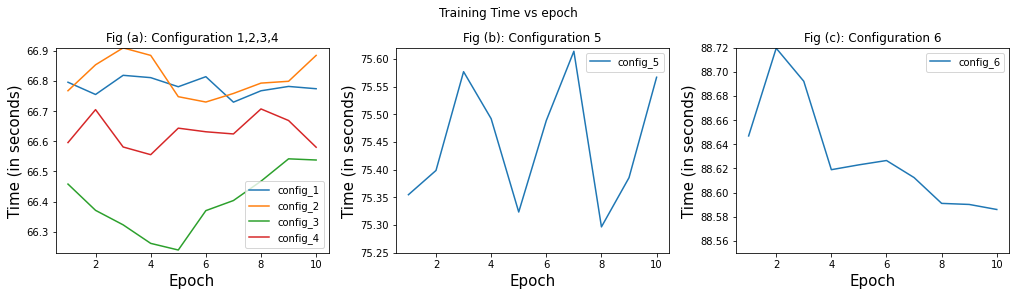

In [ ]:
import matplotlib.pyplot as plt
fig, (ax0, ax1, ax2) = plt.subplots(nrows=1, ncols=3, sharex=True,
                                    figsize=(14, 4),constrained_layout=True)
ax0.plot(Lstm['epoch'], Lstm['train_time_1'],label='config_1')
ax0.plot(Lstm['epoch'], Lstm['train_time_2'], label='config_2')
ax0.plot(Lstm['epoch'], Lstm['train_time_3'], label='config_3')
ax0.plot(Lstm['epoch'], Lstm['train_time_4'], label='config_4')
ax0.legend(loc='lower right')
ax0.set_xlabel('Epoch',fontsize=15)
ax0.set_ylabel('Time (in seconds)',fontsize=15)
ax0.set_ylim(66.23,66.91)
ax0.set_title('Fig (a): Configuration 1,2,3,4')

ax1.plot(Lstm['epoch'], Lstm['train_time_5'], label='config_5')
ax1.legend(loc='upper right')
ax1.set_xlabel('Epoch',fontsize=15)
ax1.set_ylabel('Time (in seconds)',fontsize=15)
ax1.set_ylim(75.25,75.62)
ax1.set_title('Fig (b): Configuration 5')

ax2.plot(Lstm['epoch'], Lstm['train_time_6'], label='config_6')
ax2.legend(loc='upper right')
ax2.set_ylim(88.55,88.72)
ax2.set_xlabel('Epoch',fontsize=15)
ax2.set_ylabel('Time (in seconds)',fontsize=15)
ax2.set_title('Fig (c): Configuration 6')

fig.suptitle('Training Time vs epoch')
fig.savefig('Training_time_lstm.png')
plt.show()

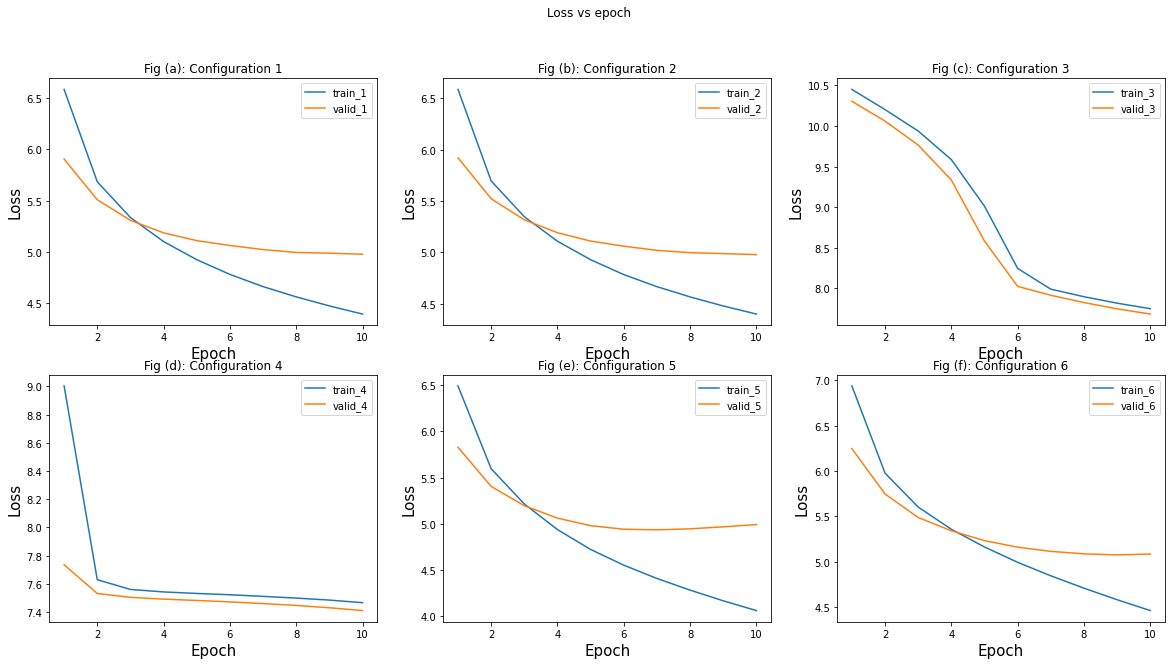

In [ ]:
# fig, (ax0, ax1, ax2, ax3, ax4, ax5) = plt.subplots(nrows=2, ncols=3, 
#                                     figsize=(20, 4))
fig, ax = plt.subplots(2, 3, figsize=(20, 10))
ax[0, 0].set_title('Fig (a): Configuration 1')
ax[0, 0].plot(Lstm['epoch'], Lstm['train_loss_1'],label='train_1')
ax[0, 0].plot(Lstm['epoch'], Lstm['val_loss_1'], label='valid_1')
ax[0, 0].legend(loc='upper right')
ax[0, 0].set_xlabel('Epoch',fontsize=15)
ax[0, 0].set_ylabel('Loss',fontsize=15)

ax[0, 1].set_title('Fig (b): Configuration 2')
ax[0, 1].plot(Lstm['epoch'], Lstm['train_loss_2'],label='train_2')
ax[0, 1].plot(Lstm['epoch'], Lstm['val_loss_2'], label='valid_2')
ax[0, 1].legend(loc='upper right')
ax[0, 1].set_xlabel('Epoch',fontsize=15)
ax[0, 1].set_ylabel('Loss',fontsize=15)

ax[0, 2].set_title('Fig (c): Configuration 3')
ax[0, 2].plot(Lstm['epoch'], Lstm['train_loss_3'],label='train_3')
ax[0, 2].plot(Lstm['epoch'], Lstm['val_loss_3'], label='valid_3')
ax[0, 2].legend(loc='upper right')
ax[0, 2].set_xlabel('Epoch',fontsize=15)
ax[0, 2].set_ylabel('Loss',fontsize=15)

ax[1, 0].set_title('Fig (d): Configuration 4')
ax[1, 0].plot(Lstm['epoch'], Lstm['train_loss_4'],label='train_4')
ax[1, 0].plot(Lstm['epoch'], Lstm['val_loss_4'], label='valid_4')
ax[1, 0].legend(loc='upper right')
ax[1, 0].set_xlabel('Epoch',fontsize=15)
ax[1, 0].set_ylabel('Loss',fontsize=15)

ax[1, 1].set_title('Fig (e): Configuration 5')
ax[1, 1].plot(Lstm['epoch'], Lstm['train_loss_5'],label='train_5')
ax[1, 1].plot(Lstm['epoch'], Lstm['val_loss_5'], label='valid_5')
ax[1, 1].legend(loc='upper right')
ax[1, 1].set_xlabel('Epoch',fontsize=15)
ax[1, 1].set_ylabel('Loss',fontsize=15)

ax[1, 2].set_title('Fig (f): Configuration 6')
ax[1, 2].plot(Lstm['epoch'], Lstm['train_loss_6'],label='train_6')
ax[1, 2].plot(Lstm['epoch'], Lstm['val_loss_6'], label='valid_6')
ax[1, 2].legend(loc='upper right')
ax[1, 2].set_xlabel('Epoch',fontsize=15)
ax[1, 2].set_ylabel('Loss',fontsize=15)

fig.suptitle('Loss vs epoch')
fig.savefig('Loss_lstm.png')
plt.show()


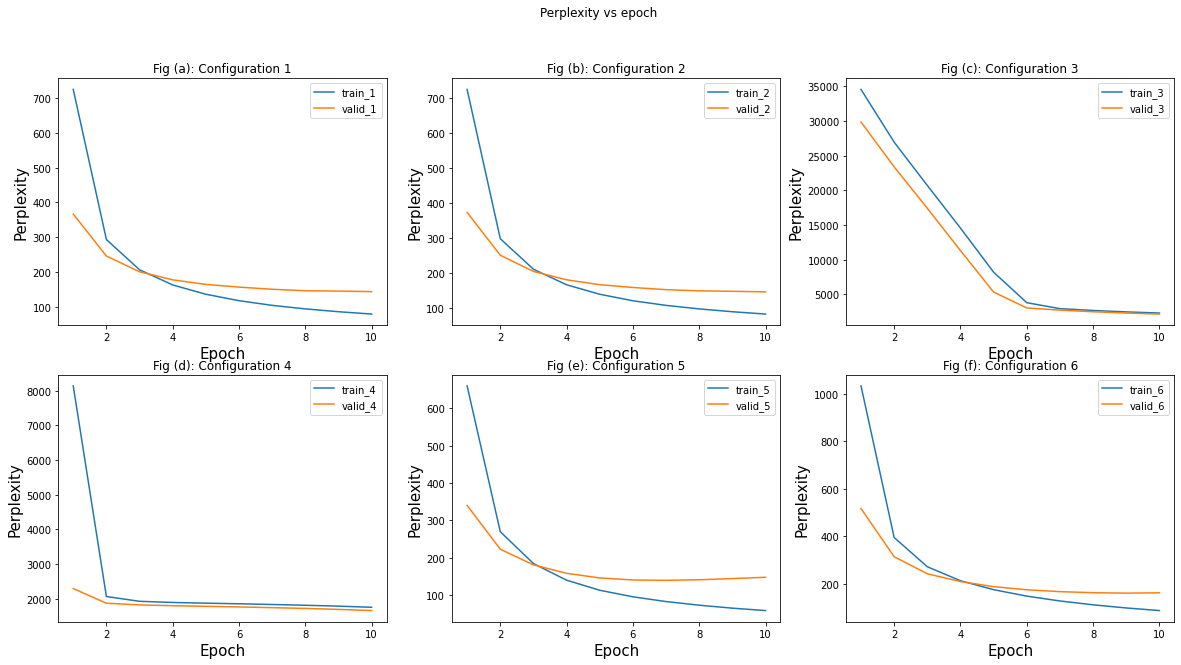

In [ ]:
# fig, (ax0, ax1, ax2, ax3, ax4, ax5) = plt.subplots(nrows=2, ncols=3, 
#                                     figsize=(20, 4))
fig, ax = plt.subplots(2, 3, figsize=(20, 10))
ax[0, 0].set_title('Fig (a): Configuration 1')
ax[0, 0].plot(Lstm['epoch'], Lstm['train_ppl_1'],label='train_1')
ax[0, 0].plot(Lstm['epoch'], Lstm['val_ppl_1'], label='valid_1')
ax[0, 0].legend(loc='upper right')
ax[0, 0].set_xlabel('Epoch',fontsize=15)
ax[0, 0].set_ylabel('Perplexity',fontsize=15)

ax[0, 1].set_title('Fig (b): Configuration 2')
ax[0, 1].plot(Lstm['epoch'], Lstm['train_ppl_2'],label='train_2')
ax[0, 1].plot(Lstm['epoch'], Lstm['val_ppl_2'], label='valid_2')
ax[0, 1].legend(loc='upper right')
ax[0, 1].set_xlabel('Epoch',fontsize=15)
ax[0, 1].set_ylabel('Perplexity',fontsize=15)

ax[0, 2].set_title('Fig (c): Configuration 3')
ax[0, 2].plot(Lstm['epoch'], Lstm['train_ppl_3'],label='train_3')
ax[0, 2].plot(Lstm['epoch'], Lstm['val_ppl_3'], label='valid_3')
ax[0, 2].legend(loc='upper right')
ax[0, 2].set_xlabel('Epoch',fontsize=15)
ax[0, 2].set_ylabel('Perplexity',fontsize=15)

ax[1, 0].set_title('Fig (d): Configuration 4')
ax[1, 0].plot(Lstm['epoch'], Lstm['train_ppl_4'],label='train_4')
ax[1, 0].plot(Lstm['epoch'], Lstm['val_ppl_4'], label='valid_4')
ax[1, 0].legend(loc='upper right')
ax[1, 0].set_xlabel('Epoch',fontsize=15)
ax[1, 0].set_ylabel('Perplexity',fontsize=15)

ax[1, 1].set_title('Fig (e): Configuration 5')
ax[1, 1].plot(Lstm['epoch'], Lstm['train_ppl_5'],label='train_5')
ax[1, 1].plot(Lstm['epoch'], Lstm['val_ppl_5'], label='valid_5')
ax[1, 1].legend(loc='upper right')
ax[1, 1].set_xlabel('Epoch',fontsize=15)
ax[1, 1].set_ylabel('Perplexity',fontsize=15)

ax[1, 2].set_title('Fig (f): Configuration 6')
ax[1, 2].plot(Lstm['epoch'], Lstm['train_ppl_6'],label='train_6')
ax[1, 2].plot(Lstm['epoch'], Lstm['val_ppl_6'], label='valid_6')
ax[1, 2].legend(loc='upper right')
ax[1, 2].set_xlabel('Epoch',fontsize=15)
ax[1, 2].set_ylabel('Perplexity',fontsize=15)

fig.suptitle('Perplexity vs epoch')
fig.savefig('Perplexity_lstm.png')
plt.show()


In [ ]:
### Vit plots

In [ ]:
vit.columns

Index(['epoch', 'train_loss_1', 'val_loss_1', 'train_accs_1', 'val_accs_1',
       'train_time_1', 'val_time_1', 'gpu_mem_1', 'train_loss_2',
       'train_loss_3', 'train_loss_4', 'train_loss_5', 'train_loss_6',
       'train_loss_7', 'val_loss_2', 'val_loss_3', 'val_loss_4', 'val_loss_5',
       'val_loss_6', 'val_loss_7', 'train_accs_2', 'train_accs_3',
       'train_accs_4', 'train_accs_5', 'train_accs_6', 'train_accs_7',
       'val_accs_2', 'val_accs_3', 'val_accs_4', 'val_accs_5', 'val_accs_6',
       'val_accs_7', 'train_time_2', 'train_time_3', 'train_time_4',
       'train_time_5', 'train_time_6', 'train_time_7', 'val_time_2',
       'val_time_3', 'val_time_4', 'val_time_5', 'val_time_6', 'val_time_7',
       'gpu_mem_2', 'gpu_mem_3', 'gpu_mem_4', 'gpu_mem_5', 'gpu_mem_6',
       'gpu_mem_7'],
      dtype='object')

In [ ]:
vit

In [ ]:
vit[['train_accs_1','train_accs_2', 'train_accs_3',
       'train_accs_4', 'train_accs_5', 'train_accs_6', 'train_accs_7']]

,train_accs_1,train_accs_2,train_accs_3,train_accs_4,train_accs_5,train_accs_6,train_accs_7
0,0.377515,0.377537,0.099337,0.152555,0.398994,0.394587,0.402756
1,0.492254,0.492210,0.116742,0.190082,0.518318,0.528690,0.534544
2,0.532385,0.532385,0.145099,0.204416,0.557870,0.572761,0.580974
3,0.555600,0.555622,0.172943,0.220397,0.584558,0.597000,0.612602
4,0.579505,0.579460,0.176438,0.233819,0.606838,0.621728,0.636930
5,0.594618,0.594618,0.181246,0.243545,0.629429,0.642050,0.660190
6,0.608173,0.608195,0.185964,0.252849,0.644364,0.661080,0.676571
7,0.623219,0.623242,0.187233,0.260061,0.659477,0.679087,0.693332
8,0.635483,0.635417,0.185608,0.268029,0.675726,0.693710,0.712251
9,0.645143,0.645121,0.183627,0.276064,0.691506,0.707755,0.723179


In [ ]:
vit[['val_accs_1','val_accs_2', 'val_accs_3', 'val_accs_4', 'val_accs_5', 'val_accs_6',
       'val_accs_7']]

,val_accs_1,val_accs_2,val_accs_3,val_accs_4,val_accs_5,val_accs_6,val_accs_7
0,0.458594,0.458594,0.109961,0.176367,0.490820,0.509766,0.506250
1,0.512109,0.512109,0.130664,0.173047,0.546484,0.558203,0.553516
2,0.546484,0.546484,0.172852,0.198633,0.582617,0.579102,0.612305
3,0.574609,0.574609,0.171289,0.226367,0.590625,0.603516,0.615625
4,0.588281,0.588281,0.182617,0.227344,0.614453,0.615625,0.627148
5,0.604297,0.604297,0.180664,0.252930,0.621094,0.631055,0.636328
6,0.603320,0.603320,0.173828,0.249805,0.631250,0.636133,0.651953
7,0.622070,0.621875,0.176563,0.260352,0.641797,0.658594,0.662500
8,0.612500,0.612500,0.171680,0.266797,0.640234,0.675977,0.686133
9,0.624414,0.624219,0.188281,0.275391,0.659961,0.669531,0.686914


In [ ]:
vit[['val_loss_1','val_loss_2', 'val_loss_3', 'val_loss_4', 'val_loss_5',
       'val_loss_6', 'val_loss_7']]

,val_loss_1,val_loss_2,val_loss_3,val_loss_4,val_loss_5,val_loss_6,val_loss_7
0,1.494339,1.494346,2.300318,2.247042,1.397760,1.375217,1.354170
1,1.357265,1.357282,2.292595,2.197374,1.263600,1.233322,1.239045
2,1.257038,1.257060,2.285312,2.151134,1.170659,1.150154,1.106818
3,1.189306,1.189323,2.278758,2.107026,1.138727,1.104466,1.071107
4,1.165253,1.165252,2.272505,2.076734,1.079186,1.081493,1.043385
5,1.120737,1.120758,2.266548,2.051297,1.068649,1.032486,1.011565
6,1.105875,1.105876,2.260729,2.026986,1.023088,1.001264,0.965056
7,1.075897,1.075958,2.255281,2.004086,1.002148,0.961028,0.952291
8,1.067032,1.067014,2.249798,1.986345,0.998262,0.945245,0.903176
9,1.044897,1.044927,2.244044,1.969948,0.947713,0.923701,0.883504


In [ ]:
vit[['train_loss_1','train_loss_2',
       'train_loss_3', 'train_loss_4', 'train_loss_5', 'train_loss_6',
       'train_loss_7']]

,train_loss_1,train_loss_2,train_loss_3,train_loss_4,train_loss_5,train_loss_6,train_loss_7
0,1.714663,1.714667,2.323634,2.279102,1.656806,1.662461,1.639070
1,1.408367,1.408377,2.294932,2.220366,1.344785,1.317822,1.289700
2,1.298188,1.298205,2.287583,2.172661,1.233449,1.197586,1.173884
3,1.234254,1.234273,2.280911,2.128207,1.155278,1.119751,1.087541
4,1.170933,1.170958,2.274525,2.091330,1.095925,1.057018,1.020221
5,1.126423,1.126453,2.268301,2.063076,1.037128,1.001170,0.958029
6,1.091073,1.091111,2.262309,2.037688,0.991447,0.953359,0.909520
7,1.056175,1.056220,2.256607,2.013403,0.951885,0.908398,0.861203
8,1.023006,1.023058,2.250921,1.989459,0.910628,0.866381,0.818968
9,0.991229,0.991289,2.245391,1.972686,0.870379,0.824738,0.778364


In [ ]:
vit[['train_time_1','train_time_2', 'train_time_3', 'train_time_4',
       'train_time_5', 'train_time_6', 'train_time_7']].cumsum()

,train_time_1,train_time_2,train_time_3,train_time_4,train_time_5,train_time_6,train_time_7
0,11.859792,12.076998,11.563724,11.909148,17.273540,17.268551,17.266895
1,23.733830,24.149465,23.207080,23.831082,34.871137,34.535524,34.506253
2,35.553541,36.177769,35.052609,35.706892,52.146227,51.803108,51.777648
3,47.324606,48.143365,46.870923,47.607667,69.407547,69.044085,69.061106
4,59.180223,60.180507,58.583226,59.492403,86.658857,86.322191,86.338202
5,70.996863,72.195950,70.330928,71.365930,103.867973,103.567508,103.572362
6,82.837919,84.229900,82.055180,83.176048,121.122545,120.828364,120.824276
7,94.846574,96.226158,93.715407,95.072365,138.510810,138.061430,138.081090
8,106.860174,108.186678,105.337849,106.852533,155.789115,155.311743,155.353820
9,118.734382,120.199561,116.993222,118.738968,173.056248,172.532863,172.659011


In [ ]:
vit[['train_accs_1','train_accs_2', 'train_accs_3',
       'train_accs_4', 'train_accs_5', 'train_accs_6', 'train_accs_7']].max()

train_accs_1    0.645143
train_accs_2    0.645121
train_accs_3    0.187233
train_accs_4    0.276064
train_accs_5    0.691506
train_accs_6    0.707755
train_accs_7    0.723179
dtype: float64

In [ ]:
vit[['val_accs_1','val_accs_2', 'val_accs_3', 'val_accs_4', 'val_accs_5', 'val_accs_6',
       'val_accs_7']].max()

val_accs_1    0.624414
val_accs_2    0.624219
val_accs_3    0.188281
val_accs_4    0.275391
val_accs_5    0.659961
val_accs_6    0.675977
val_accs_7    0.686914
dtype: float64

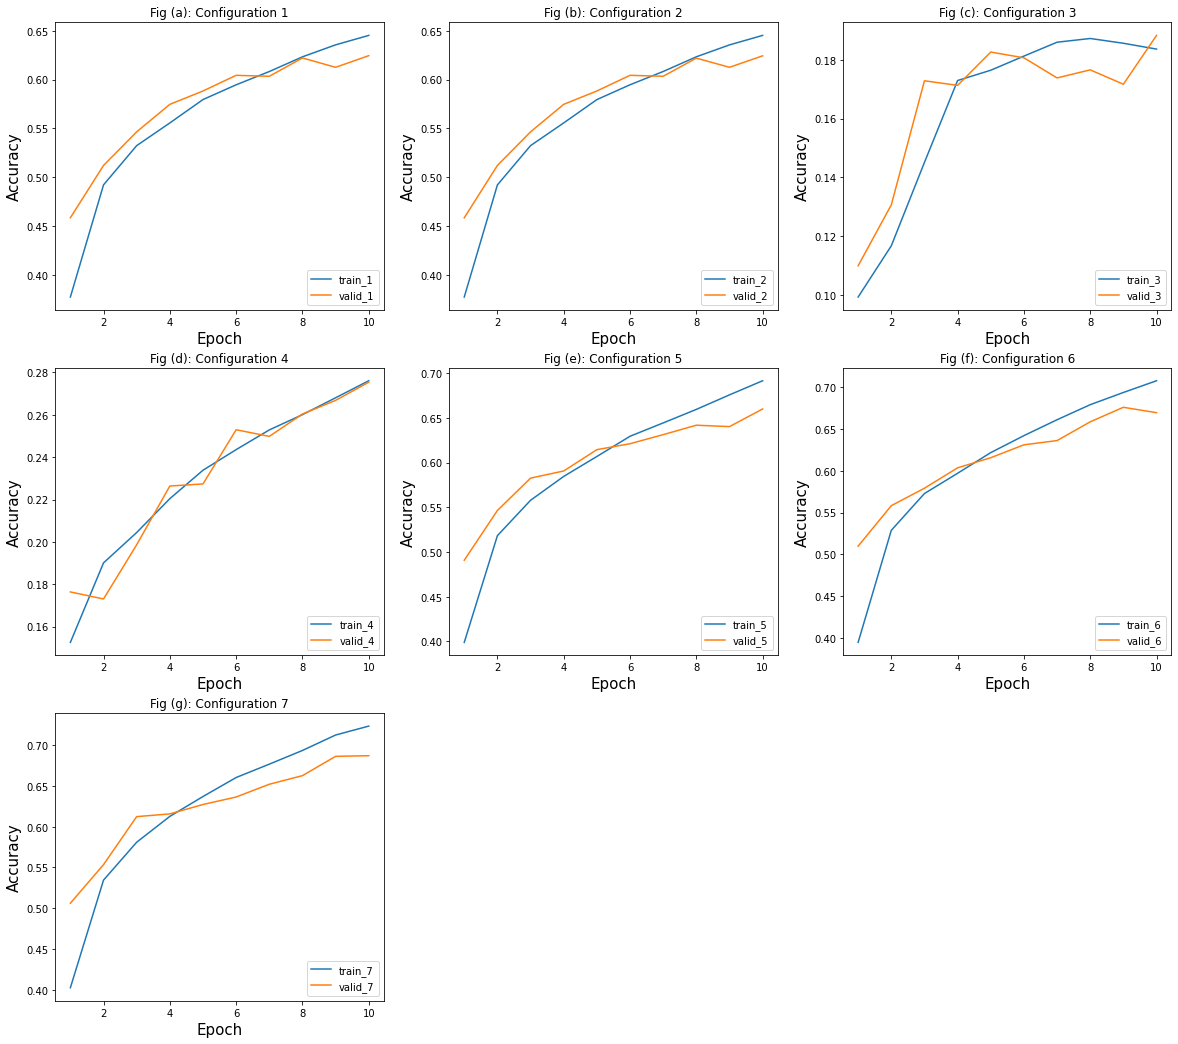

In [ ]:
# fig, (ax0, ax1, ax2, ax3, ax4, ax5) = plt.subplots(nrows=2, ncols=3, 
#                                     figsize=(20, 4))
fig, ax = plt.subplots(3, 3, figsize=(20, 18))
ax[0, 0].set_title('Fig (a): Configuration 1')
ax[0, 0].plot(vit['epoch'], vit['train_accs_1'],label='train_1')
ax[0, 0].plot(vit['epoch'], vit['val_accs_1'], label='valid_1')
ax[0, 0].legend(loc='lower right')
ax[0, 0].set_xlabel('Epoch', fontsize=15)
ax[0, 0].set_ylabel('Accuracy', fontsize=15)

ax[0, 1].set_title('Fig (b): Configuration 2')
ax[0, 1].plot(vit['epoch'], vit['train_accs_2'],label='train_2')
ax[0, 1].plot(vit['epoch'], vit['val_accs_2'], label='valid_2')
ax[0, 1].legend(loc='lower right')
ax[0, 1].set_xlabel('Epoch',fontsize=15)
ax[0, 1].set_ylabel('Accuracy',fontsize=15)

ax[0, 2].set_title('Fig (c): Configuration 3')
ax[0, 2].plot(vit['epoch'], vit['train_accs_3'],label='train_3')
ax[0, 2].plot(vit['epoch'], vit['val_accs_3'], label='valid_3')
ax[0, 2].legend(loc='lower right')
ax[0, 2].set_xlabel('Epoch',fontsize=15)
ax[0, 2].set_ylabel('Accuracy',fontsize=15)

ax[1, 0].set_title('Fig (d): Configuration 4')
ax[1, 0].plot(vit['epoch'], vit['train_accs_4'],label='train_4')
ax[1, 0].plot(vit['epoch'], vit['val_accs_4'], label='valid_4')
ax[1, 0].legend(loc='lower right')
ax[1, 0].set_xlabel('Epoch',fontsize=15)
ax[1, 0].set_ylabel('Accuracy',fontsize=15)

ax[1, 1].set_title('Fig (e): Configuration 5')
ax[1, 1].plot(vit['epoch'], vit['train_accs_5'],label='train_5')
ax[1, 1].plot(vit['epoch'], vit['val_accs_5'], label='valid_5')
ax[1, 1].legend(loc='lower right')
ax[1, 1].set_xlabel('Epoch',fontsize=15)
ax[1, 1].set_ylabel('Accuracy',fontsize=15)

ax[1, 2].set_title('Fig (f): Configuration 6')
ax[1, 2].plot(vit['epoch'], vit['train_accs_6'],label='train_6')
ax[1, 2].plot(vit['epoch'], vit['val_accs_6'], label='valid_6')
ax[1, 2].legend(loc='lower right')
ax[1, 2].set_xlabel('Epoch',fontsize=15)
ax[1, 2].set_ylabel('Accuracy',fontsize=15)

ax[2, 0].set_title('Fig (g): Configuration 7')
ax[2, 0].plot(vit['epoch'], vit['train_accs_7'],label='train_7')
ax[2, 0].plot(vit['epoch'], vit['val_accs_7'], label='valid_7')
ax[2, 0].legend(loc='lower right')
ax[2, 0].set_xlabel('Epoch',fontsize=15)
ax[2, 0].set_ylabel('Accuracy',fontsize=15)

ax[2, 1].set_visible(False)
ax[2, 2].set_visible(False)
# fig.suptitle('Accuracy vs epoch', fontsize=15)
fig.savefig('Accuracy_epoch_vit.png')
plt.show()


In [ ]:
vit['train_accs_7'].max()

0.7231793091168092

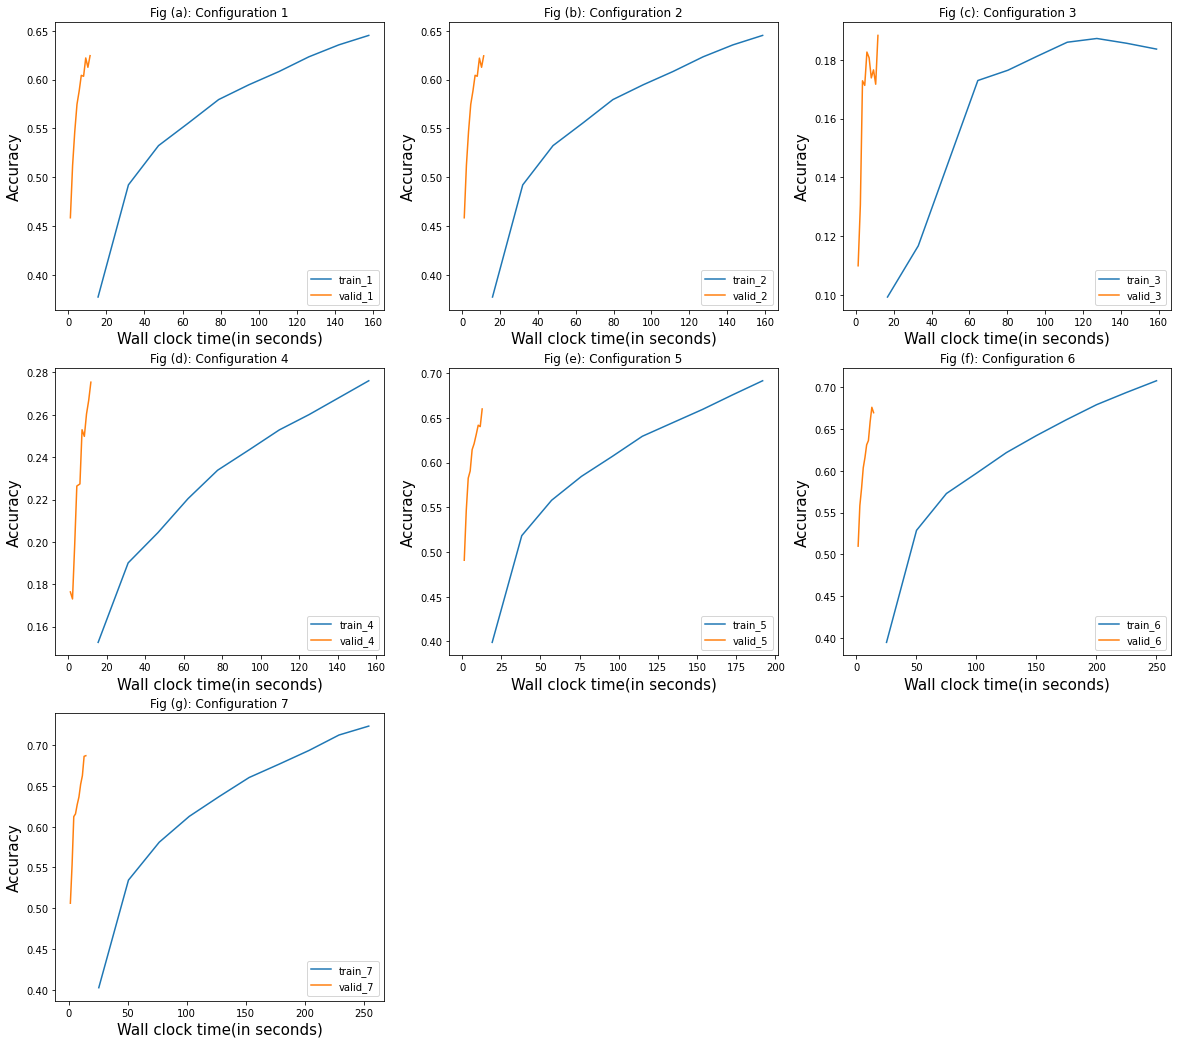

In [ ]:
# fig, (ax0, ax1, ax2, ax3, ax4, ax5) = plt.subplots(nrows=2, ncols=3, 
#                                     figsize=(20, 4))
fig, ax = plt.subplots(3, 3, figsize=(20, 18))
ax[0, 0].set_title('Fig (a): Configuration 1')
ax[0, 0].plot(vit['train_time_1'].cumsum(), vit['train_accs_1'],label='train_1')
ax[0, 0].plot(vit['val_time_1'].cumsum(), vit['val_accs_1'], label='valid_1')
ax[0, 0].legend(loc='lower right')
ax[0, 0].set_xlabel('Wall clock time(in seconds)', fontsize=15)
ax[0, 0].set_ylabel('Accuracy', fontsize=15)

ax[0, 1].set_title('Fig (b): Configuration 2')
ax[0, 1].plot(vit['train_time_2'].cumsum(), vit['train_accs_2'],label='train_2')
ax[0, 1].plot(vit['val_time_2'].cumsum(), vit['val_accs_2'], label='valid_2')
ax[0, 1].legend(loc='lower right')
ax[0, 1].set_xlabel('Wall clock time(in seconds)',fontsize=15)
ax[0, 1].set_ylabel('Accuracy',fontsize=15)

ax[0, 2].set_title('Fig (c): Configuration 3')
ax[0, 2].plot(vit['train_time_3'].cumsum(), vit['train_accs_3'],label='train_3')
ax[0, 2].plot(vit['val_time_3'].cumsum(), vit['val_accs_3'], label='valid_3')
ax[0, 2].legend(loc='lower right')
ax[0, 2].set_xlabel('Wall clock time(in seconds)',fontsize=15)
ax[0, 2].set_ylabel('Accuracy',fontsize=15)

ax[1, 0].set_title('Fig (d): Configuration 4')
ax[1, 0].plot(vit['train_time_4'].cumsum(), vit['train_accs_4'],label='train_4')
ax[1, 0].plot(vit['val_time_4'].cumsum(), vit['val_accs_4'], label='valid_4')
ax[1, 0].legend(loc='lower right')
ax[1, 0].set_xlabel('Wall clock time(in seconds)',fontsize=15)
ax[1, 0].set_ylabel('Accuracy',fontsize=15)

ax[1, 1].set_title('Fig (e): Configuration 5')
ax[1, 1].plot(vit['train_time_5'].cumsum(), vit['train_accs_5'],label='train_5')
ax[1, 1].plot(vit['val_time_5'].cumsum(), vit['val_accs_5'], label='valid_5')
ax[1, 1].legend(loc='lower right')
ax[1, 1].set_xlabel('Wall clock time(in seconds)',fontsize=15)
ax[1, 1].set_ylabel('Accuracy',fontsize=15)

ax[1, 2].set_title('Fig (f): Configuration 6')
ax[1, 2].plot(vit['train_time_6'].cumsum(), vit['train_accs_6'],label='train_6')
ax[1, 2].plot(vit['val_time_6'].cumsum(), vit['val_accs_6'], label='valid_6')
ax[1, 2].legend(loc='lower right')
ax[1, 2].set_xlabel('Wall clock time(in seconds)',fontsize=15)
ax[1, 2].set_ylabel('Accuracy',fontsize=15)

ax[2, 0].set_title('Fig (g): Configuration 7')
ax[2, 0].plot(vit['train_time_7'].cumsum(), vit['train_accs_7'],label='train_7')
ax[2, 0].plot(vit['val_time_7'].cumsum(), vit['val_accs_7'], label='valid_7')
ax[2, 0].legend(loc='lower right')
ax[2, 0].set_xlabel('Wall clock time(in seconds)',fontsize=15)
ax[2, 0].set_ylabel('Accuracy',fontsize=15)

ax[2, 1].set_visible(False)
ax[2, 2].set_visible(False)
# fig.suptitle('Accuracy vs epoch', fontsize=15)
fig.savefig('Accuracy_time_vit.png')
plt.show()
